In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import interpolate

# Creating final dataset
df = []

# Read class data
data = pd.read_csv('../data/files.csv')

# Time series features data
tsfeat = pd.read_csv('../data/ciao.csv')
tsfeat=tsfeat.dropna(axis=1) # delete NaN columns
tsfeat = tsfeat.drop('Unnamed: 0', axis=1)
tsfeat = tsfeat.loc[:,~tsfeat.columns.str.startswith('3_')]

i = 0
for filename in os.listdir('../data/Train2'):
    df.append(pd.read_csv(os.path.join('../data/Train2',filename),header = None, names = ['x','y','z','time']))
    i = i + 1    

data['class'] = data['class'].replace([1,2,3,4,5,6,7,8,9,10],[1,1,1,1,1,2,2,2,3,3]) # Classificazione richiesta con 3 classi (moving,falling,other)
#data['class'] = data['class'].replace([1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,6,6,7,8]) # Classificazione con 8 classi

In [2]:
v_max = []
v_min = []
for i in range(len(df)):
    v_max.append(np.max(np.diff(df[i]['time'])))
    v_min.append(np.min(np.diff(df[i]['time'])))

print(np.max(v_max))
print(np.min(v_min)) # Problema con qualche serie temporale in cui i tempi vengono presi male, si potrebbero togliere e trattare come outliers

0.6200000000000045
0.0


In [3]:
df[0]

,x,y,z,time
0,0.136780,0.98086,-0.028898,1.8604
1,0.140570,0.98086,-0.020864,1.8652
2,0.132880,0.98086,-0.033096,1.8701
3,0.136890,0.98876,-0.032577,1.8750
4,0.129210,0.98876,-0.044808,1.8799
...,...,...,...,...
2311,0.104190,0.98481,-0.016365,13.1450
2312,0.104760,1.00060,-0.035232,13.1490
2313,0.112340,0.98481,-0.019479,13.1540
2314,0.100410,0.98086,-0.024478,13.1590


In [15]:
for i in df[0].columns[:-1]:
    print(np.array(df[0][i]))

[0.13678  0.14057  0.13288  ... 0.11234  0.10041  0.084561]
[0.98086 0.98086 0.98086 ... 0.98481 0.98086 0.99666]
[-0.028898 -0.020864 -0.033096 ... -0.019479 -0.024478 -0.033282]


In [71]:
len(df)

468

In [16]:
import sys
from features import Features
import inspect
import pandas as pd
import numpy as np

In [83]:
import sys
from features import Features
import inspect
import pandas as pd
import numpy as np

def calc_features(df):
    f = Features()
    attrs = (getattr(f, name) for name in dir(f))
    methods = filter(inspect.ismethod, attrs)
    df_features = pd.DataFrame()

    for signals in df:
        names = []
        values = []
        for columns in signals.columns[:-1]: 
            signal = np.array(signals[columns])
            f = Features()
            attrs = (getattr(f, name) for name in dir(f))
            methods = filter(inspect.ismethod, attrs)
            methods = filter(inspect.ismethod, attrs)
            for method in methods:
                names.append(method.__name__ + '_' + columns)
                values.append(getattr(f, method.__name__)(signal))
        
        df_new = pd.DataFrame(values, index=names).T
        if df_features.empty:
            df_features = df_new
        else:
            df_features = pd.concat([df_features,df_new])
                
    return df_features

In [84]:
ans = calc_features(df)

[0.13678  0.14057  0.13288  ... 0.11234  0.10041  0.084561]
[0.98086 0.98086 0.98086 ... 0.98481 0.98086 0.99666]
[-0.028898 -0.020864 -0.033096 ... -0.019479 -0.024478 -0.033282]
[-0.14    -0.16376 -0.15573 ... -0.1896  -0.17401 -0.17494]
[0.95322 0.95717 0.96902 ... 0.81105 0.8387  0.86239]
[0.20337 0.18977 0.19073 ... 0.11143 0.12877 0.15994]
[-0.94935 -0.96907 -0.96104 ...  0.16911  0.18067  0.15383]
[0.17919 0.1555  0.15945 ... 1.7233  1.7746  1.7628 ]
[0.19967 0.18588 0.18668 ... 0.50431 0.52177 0.4768 ]
[-0.23387 -0.24535 -0.26442 ... -0.86507 -0.89315 -0.90209]
[ 0.90583  0.92163  0.95322 ... -0.26311 -0.32235 -0.34209]
[0.51324  0.49329  0.45759  ... 0.075316 0.071604 0.10118 ]
[ 1.4388e-01  1.3550e-01  1.3930e-01  1.5147e-01  1.4299e-01  1.2255e-01
  1.1417e-01  8.1348e-02  4.8997e-02  1.6977e-02  5.2809e-03  5.8492e-03
  6.7439e-03  1.5925e-02  3.4264e-02  5.9930e-02  9.7307e-02  1.3801e-01
  1.8661e-01  2.7483e-01  3.4800e-01  4.0467e-01  4.4563e-01  4.6617e-01
  4.6184e-01

In [85]:
ans

,auc_x,autocorr_x,calc_max_x,calc_mean_x,calc_median_x,calc_min_x,calc_std_x,calc_var_x,distance_x,ecdf_percentile_x,...,median_abs_deviation_z,median_abs_diff_z,median_diff_z,negative_turning_z,pk_pk_distance_z,positive_turning_z,slope_z,sum_abs_diff_z,total_energy_z,zero_cross_z
0,1.599117,91.652348,0.6961,0.066748,0.060569,-0.78532,0.187399,0.035118,2316.616462,"(-0.039234, 0.15282)",...,0.073432,0.010661,-0.000833,509,0.62145,507,-0.000002,37.611796,1.88118,116
0,2.228151,202.959798,0.47922,-0.163388,-0.12768,-1.6041,0.267563,0.07159,2066.8581,"(-0.28679, 0.011539)",...,0.082167,0.013575,0.001584,372,1.7044,370,-0.000027,56.912589,6.634859,116
0,3.808457,656.284386,0.18067,-0.478757,-0.435565,-1.0578,0.436361,0.190411,1563.142183,"(-0.96161, -0.016654)",...,0.06262,0.00978,0.00008,374,0.626686,373,0.00008,20.208062,19.354454,0
0,4.785387,991.585349,0.28195,-0.453906,-0.090911,-4.3677,0.544561,0.296547,1975.389105,"(-0.98956, 0.019951)",...,0.178313,0.009205,-0.000386,494,4.39418,493,-0.000234,34.998092,21.658554,14
0,1.26176,91.898041,1.3332,0.255571,0.24901,-0.33454,0.178114,0.031725,947.099686,"(0.1804, 0.3259)",...,0.056013,0.010196,0.000285,205,1.34445,204,-0.000025,17.041903,7.276137,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.71263,86.968436,0.36233,-0.09311,-0.078601,-0.72418,0.159402,0.025409,2552.396147,"(-0.19181, 0.023788)",...,0.05372,0.012153,0.0005,495,1.68476,497,-0.000023,67.862965,4.065731,169
0,3.938283,594.838287,0.32697,-0.328268,-0.38816,-4.473,0.419891,0.176308,2097.584552,"(-0.6506, 0.039459)",...,0.23093,0.008836,-0.000078,527,2.71515,530,-0.000539,46.870154,59.986229,129
0,3.988215,239.248237,1.0628,0.127228,0.1285,-0.53611,0.192885,0.037205,4483.298852,"(-0.020133, 0.24372)",...,0.074872,0.014902,-0.000148,801,1.2835,800,-0.000005,110.640979,8.417357,228
0,1.660595,87.445377,0.56934,-0.067673,-0.039544,-0.70102,0.174996,0.030624,2484.123617,"(-0.21337, 0.022257)",...,0.04949,0.01157,0.0002,557,0.894379,556,-0.000004,42.373958,24.504465,0


In [54]:
def pre_process_data(data_acc, fs):
    """This function interpolates the accelerometer and gyroscope data to 
    the same time interval.

    Parameters
    ----------
    data_acc nd-array
    Accelerometer data of specified activity
    fs int
    Sampling frequency

    Returns
    -------
    Interpolated data (nd-array)

    """
    time_acc = (data_acc.iloc[:, 3]) - data_acc.iloc[0, 3]
    data_act_acc = data_acc.iloc[:, 0:3]

    # time interval for interpolation
    time_acc = np.array(time_acc)
    t0 = time_acc[0]
    tn = time_acc[-1]
    time_new = np.linspace(t0, tn, int((tn - t0) / ((1 / fs))))

    data_act_acc = np.array(data_act_acc)
    # interpolation
    acc_data = np.array([interpolate.interp1d(time_acc, data_act_acc[:, ax])(time_new) for ax in range(np.shape(data_act_acc)[1])]).T

    # concatenate interpolated data
    data = np.column_stack((acc_data, time_new))
    data = pd.DataFrame(data, columns = ['x', 'y', 'z', 'time'])

    return data

In [4]:
df_resampled = df.copy()
for i in range(len(df)):
    df_resampled[i] = pre_process_data(df[i], 200)

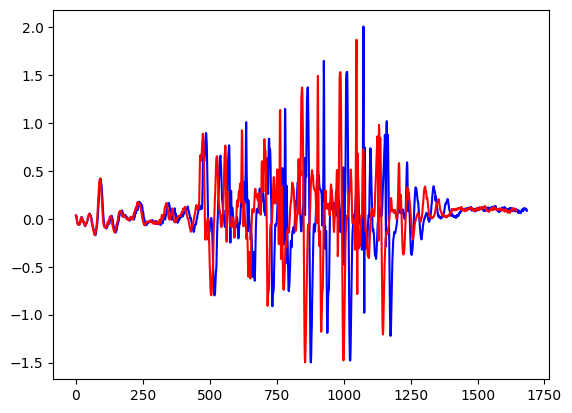

In [5]:
# Plot example
ind = 20
plt.plot(df[ind]['x'], color = 'b')
plt.plot(df_resampled[ind]['x'], color = 'r')

In [6]:
df_resampled[ind].head()

,x,y,z,time
0,0.034048,1.004600,0.173900,0.000000
1,0.023027,1.024312,0.138692,0.005005
2,0.026632,1.036261,0.150801,0.010010
3,-0.001721,1.067666,0.156465,0.015015
4,-0.016859,1.055854,0.124125,0.020019


In [7]:
df[ind].head()

,x,y,z,time
0,0.034048,1.0046,0.17390,24.277
1,0.023023,1.0243,0.13868,24.282
2,0.026687,1.0362,0.15079,24.287
3,-0.001676,1.0677,0.15656,24.292
4,-0.016814,1.0559,0.12419,24.297


In [8]:
df[ind]['time'][2]-df[ind]['time'][1]

0.004999999999999005

In [9]:
df_resampled[ind]['time'][2]-df_resampled[ind]['time'][1]

0.005004869141813755

No missing data at all

In [10]:
np.where(pd.isna(df)==True)

(array([], dtype=int64),)

# Functional outliers

In [11]:
def pre_process_data(data_acc, n_points):
    """This function interpolates the accelerometer and gyroscope data to 
    the same time interval.

    Parameters
    ----------
    data_acc nd-array
    Accelerometer data of specified activity
    fs int
    Sampling frequency

    Returns
    -------
    Interpolated data (nd-array)

    """
    time_acc = (data_acc.iloc[:, 3]) - data_acc.iloc[0, 3]
    data_act_acc = data_acc.iloc[:, 0:3]

    # time interval for interpolation
    time_acc = np.array(time_acc)
    t0 = time_acc[0]
    tn = time_acc[-1]
    time_new = np.linspace(t0, tn, int(n_points))

    data_act_acc = np.array(data_act_acc)
    # interpolation
    acc_data = np.array([interpolate.interp1d(time_acc, data_act_acc[:, ax])(time_new) for ax in range(np.shape(data_act_acc)[1])]).T

    # concatenate interpolated data
    data = np.column_stack((acc_data, time_new))
    data = pd.DataFrame(data, columns = ['x', 'y', 'z', 'time'])

    return data

In [12]:
max([len(df[i]) for i in range(len(df))])

5146

In [13]:
df_same_len = df.copy()
for i in range(len(df)):
    df_same_len[i] = pre_process_data(df[i], 10000)

In [18]:
data_matrix_x = [list(df_same_len[i]['x']) for i in range(len(df))]
grid_points = list(df_same_len[0]['time'])

In [19]:
import skfda
fd = skfda.FDataGrid(data_matrix_x, grid_points)
out_detector = skfda.exploratory.outliers.BoxplotOutlierDetector()
ans = out_detector.fit_predict(fd)

In [20]:
np.where(ans==-1)

(array([ 43,  65,  86, 160, 176, 239, 296, 311, 326, 379, 389]),)

In [17]:
import skfda
data_matrix = [[1, 1, 2, 3, 2.5, 2],
               [0.5, 0.5, 1, 2, 1.5, 1],
               [-1, -1, -0.5, 1, 1, 0.5],
               [-0.5, -0.5, -0.5, -1, -1, -1]]
grid_points = [0, 2, 4, 6, 8, 10]
fd = skfda.FDataGrid(data_matrix, grid_points)
out_detector = skfda.exploratory.outliers.BoxplotOutlierDetector()
out_detector.fit_predict(fd)

array([-1,  1,  1, -1])

In [ ]:
features_path = kwargs.get('features_path', None)
names = kwargs.get('header_names', None)
